In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from random import random
import copy as copy

import sys
sys.path.append(sys.path[0][:sys.path[0].rfind('/')])
from StabilizerCircuits import *

# !!!
# IMPORTANT INFO
# GATES AND MEASUREMENT CHANGE THE STATE EVEN IF THERE IS NO '='.

In [2]:
def non_clifford_gate(tableau, a, probabilities, gates):
    if len(probabilities) != len(gates):
        print('Error in non_clifford_gate')
    prob = random()
    for i in range(len(probabilities)):
        if p <= probabilities[i]:
            tableau = gates[i](tableau, a)
            break
        else:
            p -= probabilities[i]
    return tableau

# Intro

In [3]:
# initialize state |00..00>
n = 10
table = init_state0(n)
# get stabilizers (first half of the list) and destabilizers (second half) of the state
get_stabilizers(table)

['+ZIIIIIIIII',
 '+IZIIIIIIII',
 '+IIZIIIIIII',
 '+IIIZIIIIII',
 '+IIIIZIIIII',
 '+IIIIIZIIII',
 '+IIIIIIZIII',
 '+IIIIIIIZII',
 '+IIIIIIIIZI',
 '+IIIIIIIIIZ',
 '+XIIIIIIIII',
 '+IXIIIIIIII',
 '+IIXIIIIIII',
 '+IIIXIIIIII',
 '+IIIIXIIIII',
 '+IIIIIXIIII',
 '+IIIIIIXIII',
 '+IIIIIIIXII',
 '+IIIIIIIIXI',
 '+IIIIIIIIIX']

In [4]:
# create circuit of 50 qubis, make some gates and measure!
n = 50 # n > 12
table = init_state0(n)

table = X_gate(table, 9)
table = CNOT(table, 9, 11)
table = Hadamard(table, 2)
table = X_gate(table, 5)
table = iSWAP(table, 5, 6)

for i in range(n):
    table, m = measure(table, i)
    print(i, m)

0 1
1 1
2 -1
3 1
4 1
5 1
6 -1
7 1
8 1
9 -1
10 1
11 -1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1


# Time damping single qubit

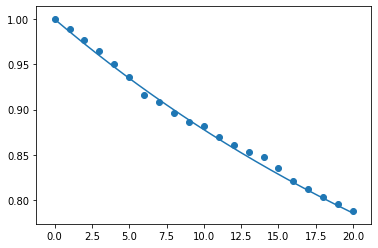

In [5]:
def single_qubit_theory(N_cycle, t_cycle, T1, Tf):
    time = np.linspace(0, N_cycle*t_cycle, 1000)
    F_phys = 1/6 * (1 + np.exp(-time/T1)) + 1/3 * (1 + np.exp(-time*(1/2/T1+1/Tf)))
    epsilon = t_cycle/3/T1 + t_cycle/3/Tf
    return(time/t_cycle, F_phys, epsilon)


n = 1
N = 1000
m = np.zeros((N, 21))
m0 = np.zeros((N, 21))
T1 = 30
t = 0.84
for k in range(N):
    table = init_state0(n)
    for i in range(0, 21):
        table, m[k, i] = measure(table, 0)
        table = amplitude_damping(table, 0, t, T1)
        
# for k in range(N):
#     table = init_state0(n)
#     table = X_gate(table, 0)
#     for i in range(0, 21):
#         table, m0[k, i] = measure(table, 0)
#         table = amplitude_damping(table, 0, t, T1)

theory = single_qubit_theory(N_cycle = 20, t_cycle = 0.84, T1 = T1, Tf = 60)
plt.plot(theory[0], theory[1])
plt.scatter(np.linspace(0, 20, 21), (np.mean(m, axis = 0)+1)/2)

In [6]:
np.mean(m, axis = 0)

array([1.   , 0.948, 0.892, 0.86 , 0.808, 0.764, 0.728, 0.676, 0.634,
       0.602, 0.544, 0.502, 0.494, 0.478, 0.458, 0.444, 0.424, 0.396,
       0.378, 0.376, 0.356])

In [11]:
table = init_state0(n)
table = Hadamard(table, 0)

table_tmp, m = measure(table.copy(), 0)
print(m)
table, m = measure(table, 0)
print(m)
table, m = measure(table, 0)
print(m)

1
-1
-1


# Ideal [5,1,3]

In [6]:
def cycle10(table):
    n = 10
    m_data = np.zeros((n//2))
    m_ancilla = np.zeros((n//2))
    
    even = np.arange(n//2)*2 # ancilla qubits
    odd = np.arange(n//2)*2 + 1 # data qubits
    
    # correction cycle
    for i in even:
        table = Hadamard(table, i)
    for i in even:
        table = iSWAP(table, i, i+1)
    for i in even:
        table = Phase(table, i)
        table = Hadamard(table, i)
    for i in odd:
        table = iSWAP(table, i, (i+1)%n)
    for i in even:
        table = iSWAP(table, i, i+1)
    for i in even:
        table = Z_gate(table, i)
        table = Hadamard(table, i)
    for i in odd:
        table = iSWAP(table, i, (i+1)%n)
    for i in even:
        table = Hadamard(table, i)
        table = Phase(table, i+1)
        
        
    # ancilla measurement
    for i in even:
        table, m_ancilla[i//2] = measure(table, i)
        if m_ancilla[i//2] == -1:
            table = X_gate(table, i)
    
    # data measurement
    table_tmp = copy.copy(table)
    for i in odd:
        table_tmp, m_data[(i-1)//2] = measure(table_tmp, i)
        
    return table, m_data, m_ancilla

In [7]:
N = 10
N_run = 1
N_cycle = 20
M_data = np.zeros((N_run, N_cycle, N//2))
M_ancilla = np.zeros((N_run, N_cycle, N//2))

for n_run in range(0, N_run):
    table = init_state0(N)
    for n_cycle in range(0, N_cycle):
        table, M_data[n_run, n_cycle], M_ancilla[n_run, n_cycle] = cycle10(table)

print(np.prod(M_data, axis = 2))
M_ancilla

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


array([[[ 1., -1.,  1.,  1., -1.],
        [ 1.,  1., -1.,  1., -1.],
        [-1.,  1., -1.,  1.,  1.],
        [-1.,  1.,  1., -1.,  1.],
        [ 1., -1.,  1., -1.,  1.],
        [ 1., -1.,  1.,  1., -1.],
        [ 1.,  1., -1.,  1., -1.],
        [-1.,  1., -1.,  1.,  1.],
        [-1.,  1.,  1., -1.,  1.],
        [ 1., -1.,  1., -1.,  1.],
        [ 1., -1.,  1.,  1., -1.],
        [ 1.,  1., -1.,  1., -1.],
        [-1.,  1., -1.,  1.,  1.],
        [-1.,  1.,  1., -1.,  1.],
        [ 1., -1.,  1., -1.,  1.],
        [ 1., -1.,  1.,  1., -1.],
        [ 1.,  1., -1.,  1., -1.],
        [-1.,  1., -1.,  1.,  1.],
        [-1.,  1.,  1., -1.,  1.],
        [ 1., -1.,  1., -1.,  1.]]])